Algoritmos de clusterizacion

## Parte 0. Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
### 3. Dataframe y archivo para analisis descriptivo procesado, desarrollo supuestos estadisticos (Histogramas y estadistica general)
df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024 = pd.read_csv('/content/gdrive/MyDrive/SIMA/FINAL/df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024.csv')


ParserError: Error tokenizing data. C error: Expected 1 fields in line 3, saw 2119


In [ ]:
contaminantes_y_coords = df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024[['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'SO2', 'latitud', 'longitud']]


In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.8 MB/s eta 0:00:00


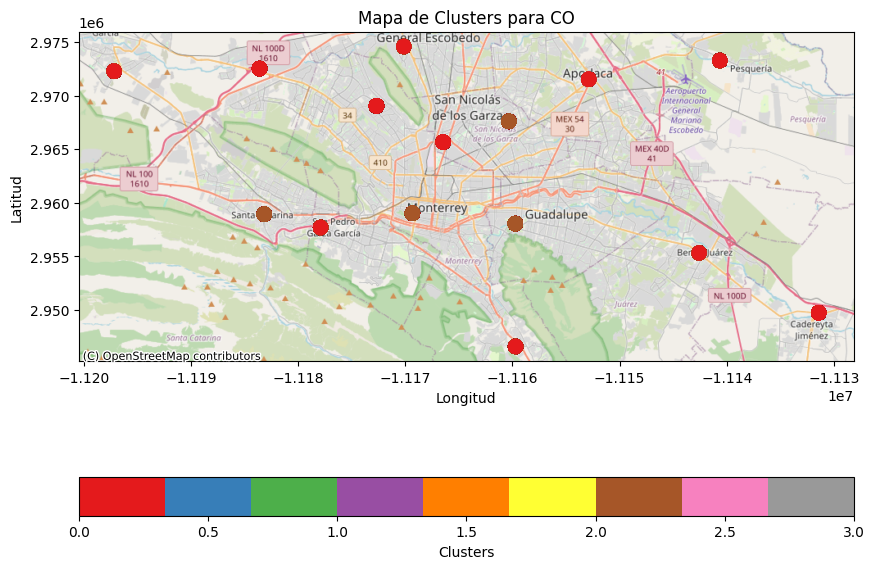

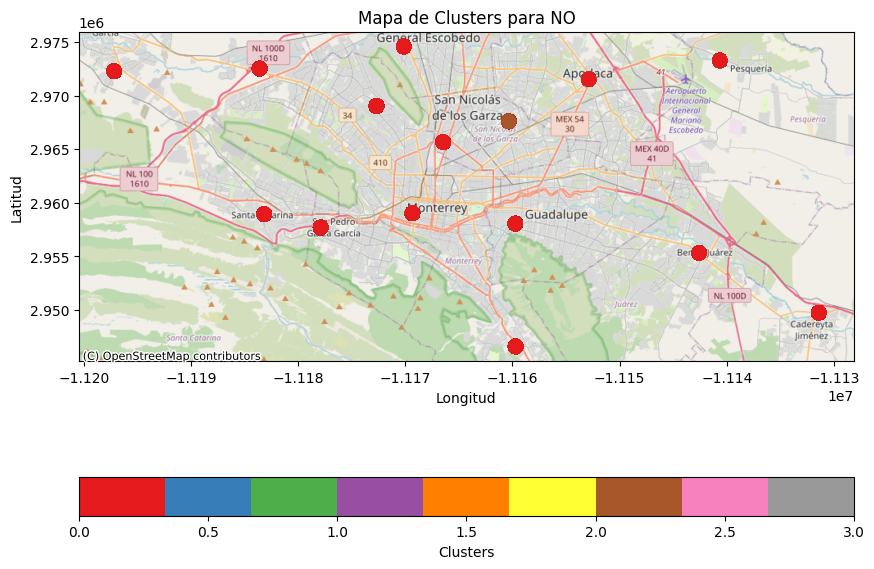

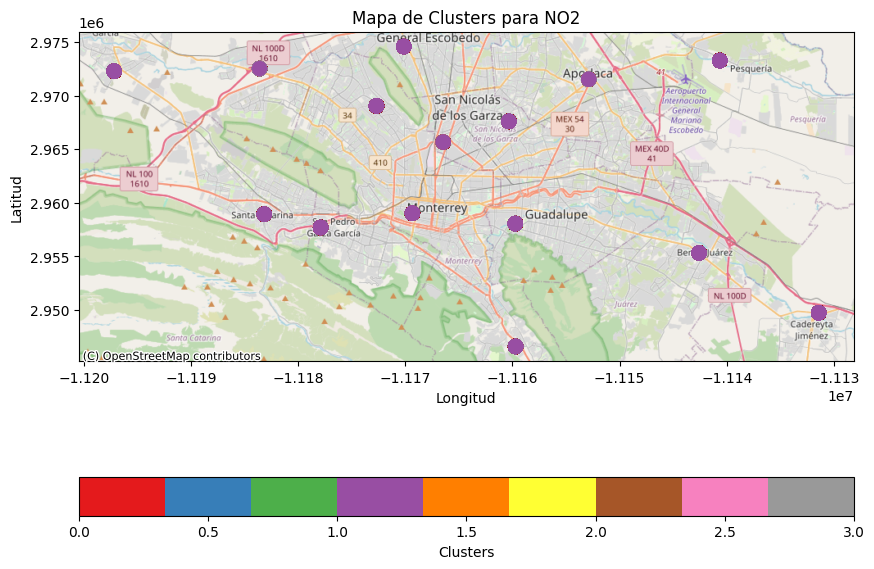

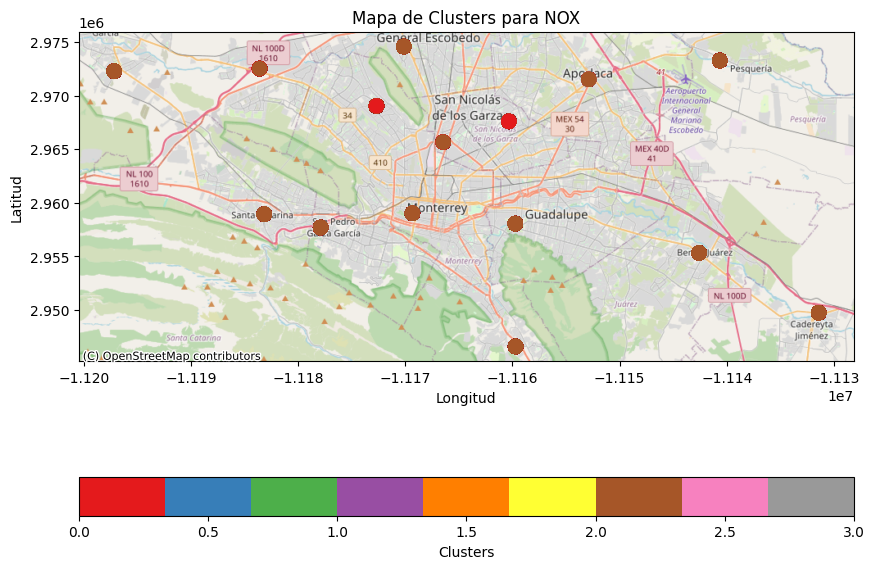

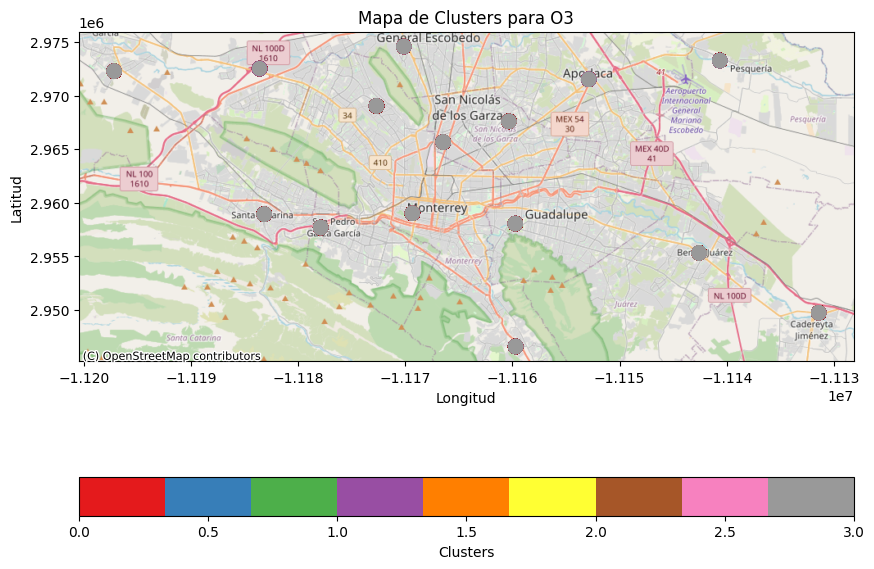

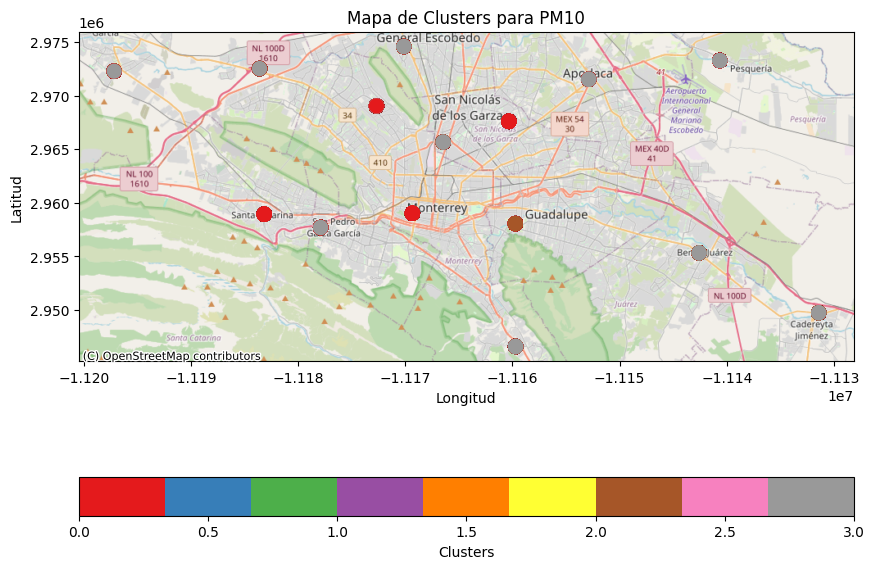

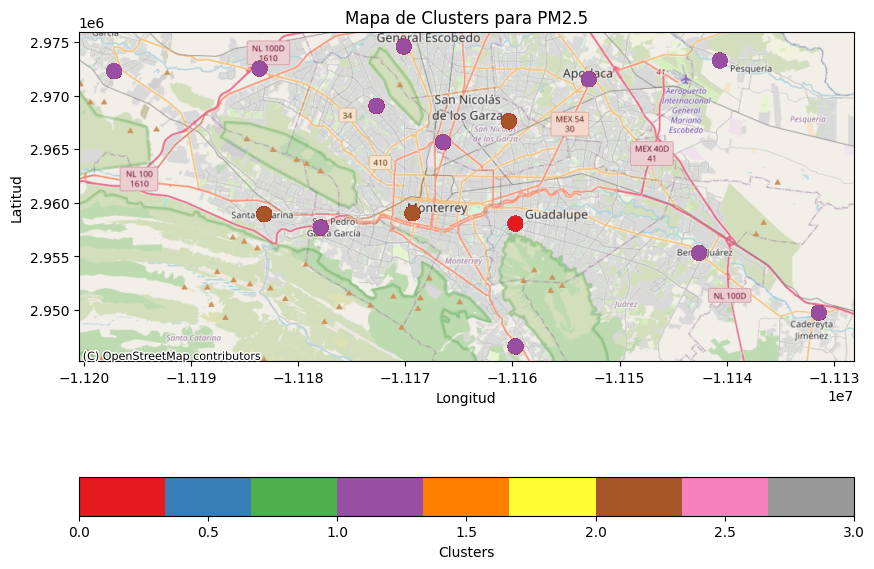

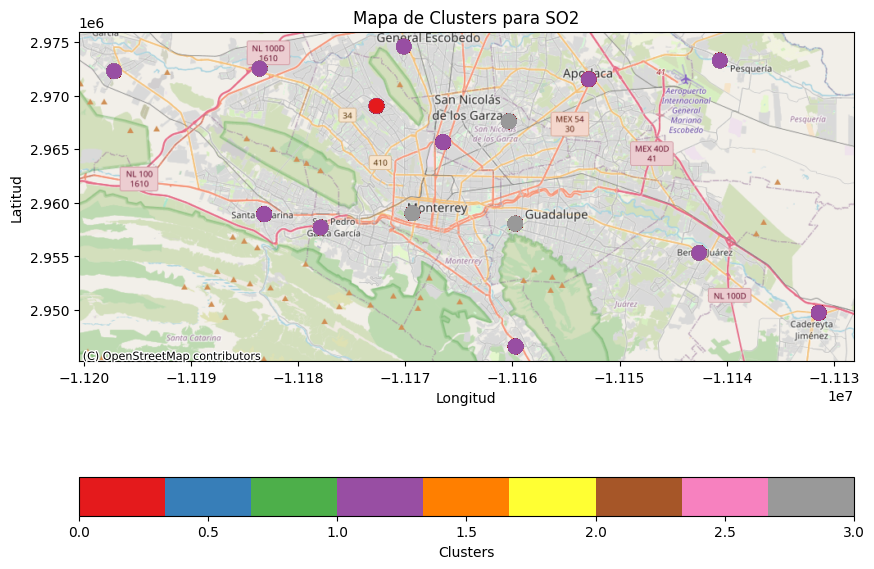

In [ ]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import contextily as ctx  # Para añadir mapas base

# Convertir el DataFrame a un GeoDataFrame
gdf = gpd.GeoDataFrame(df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024,
                       geometry=gpd.points_from_xy(df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024['longitud'],
                                                  df_Completo_Imputado_Todascolumnas_SinEstandarizar_2022_2024['latitud']))

# Establecer CRS a WGS84 (EPSG:4326) y luego convertir a Web Mercator (EPSG:3857) para compatibilidad con contextily
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

# Lista de contaminantes para los que se creará un mapa
contaminantes = ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'SO2']

# Crear un mapa para cada contaminante
for contaminante in contaminantes:
    # Normalizar los datos del contaminante específico
    scaler = StandardScaler()
    contaminante_normalizado = scaler.fit_transform(gdf[[contaminante]])

    # Aplicar KMeans para agrupar las estaciones por contaminante
    n_clusters = 4  # Ajusta este valor según lo que quieras explorar
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    gdf[f'cluster_{contaminante}'] = kmeans.fit_predict(contaminante_normalizado)

    # Crear la figura del mapa
    fig, ax = plt.subplots(figsize=(10, 10))

    # Dibujar las estaciones con los colores de los clusters
    gdf.plot(column=f'cluster_{contaminante}',
             cmap='Set1',
             ax=ax,
             legend=True,
             legend_kwds={'label': "Clusters",
                          'orientation': "horizontal"},
             markersize=100)

    # Añadir mapa base de OpenStreetMap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Añadir título y etiquetas
    ax.set_title(f'Mapa de Clusters para {contaminante}')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')

    # Mostrar el mapa
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Cargar los datos
df = pd.read_csv('/content/gdrive/MyDrive/SIMA/FINAL/base_cocinada_2022_2024.csv')

# Convertir la columna de fecha a formato datetime si no lo está
df['date'] = pd.to_datetime(df['date'])

# Lista de columnas a imputar
columns_to_impute = ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'SO2', 'WSR', 'WDR']

# Función para crear secuencias de datos
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Función para imputar los valores faltantes por mes
def impute_monthly(group, sequence_length=10, epochs=25, batch_size=32):
    # Separar las filas con y sin NaNs en este mes
    df_numeric = group.dropna(subset=columns_to_impute)  # Filas sin NaN
    df_nan = group[group[columns_to_impute].isna().any(axis=1)]  # Filas con NaN

    if df_numeric.empty or df_nan.empty:
        # Si no hay datos sin NaNs o no hay NaNs para imputar en este mes, devolver el grupo sin cambios
        return group

    # Normalizar los datos numéricos
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_numeric_scaled = scaler.fit_transform(df_numeric[columns_to_impute])

    # Crear secuencias de datos
    X, y = create_sequences(df_numeric_scaled, sequence_length)

    # Definir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)

    # Imputar los valores faltantes (NaNs) en las filas que los tienen
    df_nan_scaled = scaler.transform(df_nan[columns_to_impute])

    # Crear secuencias de entrada para las filas con NaNs
    X_nan = []
    for i in range(len(df_nan_scaled)):
        if i >= sequence_length:
            X_nan.append(df_nan_scaled[i-sequence_length:i])

    X_nan = np.array(X_nan)

    if len(X_nan) > 0:
        # Predecir los valores para las filas con NaNs
        predicted_nan_values = model.predict(X_nan)

        # Invertir la normalización para obtener los valores originales
        predicted_nan_values_rescaled = scaler.inverse_transform(predicted_nan_values)

        # Reemplazar los valores NaN originales con las predicciones
        df_imputed = df_nan.copy()
        df_imputed.loc[df_nan.index[:len(predicted_nan_values_rescaled)], columns_to_impute] = predicted_nan_values_rescaled

        # Forzar que no queden NaNs copiando la fila anterior donde sea necesario
        df_imputed.fillna(method='ffill', inplace=True)

        # Combinar el dataframe imputado con las filas originales sin NaNs
        group = pd.concat([df_numeric, df_imputed]).sort_index()

    # Asegurarse de que no queden NaNs en el grupo
    group.fillna(method='ffill', inplace=True)

    return group

# Agrupar por año y mes y aplicar la imputación por cada mes
df_final = df.groupby(df['date'].dt.to_period('M')).apply(impute_monthly)

# Restablecer el índice para que coincida con el original
df_final = df_final.reset_index(drop=True)

# Verificar que ya no haya NaNs
print(df_final.isna().sum())